## Predict Suicidal Ideation Based on Tweets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import nltk
import pickle
import numpy as np
import collections
import pandas as pd
import tensorflow as tf
from sklearn import tree
from textblob import Word
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.models import Sequential
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from keras.layers import Conv1D ,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout, Activation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten
%matplotlib inline

Suicide = pd.read_csv("twitter-suicidal_data.csv",encoding ="ISO-8859-1")
Suicide.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [ ]:
Suicide.shape                                                 #shape of the dataset

(9119, 2)

In [ ]:
Suicide['tweet']=Suicide['tweet'].fillna("")                  #remove all the null value

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import re

def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove non-alphabetic characters and convert text to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words and special characters
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalnum()]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_text = [stemmer.stem(word) for word in filtered_tokens]

    # Join the stemmed tokens back into a single string
    processed_text = ' '.join(stemmed_text)
    return processed_text

# Apply the preprocessing function to the 'tweet' column
Suicide['processed_tweet'] = Suicide['tweet'].apply(preprocess_text)

In [ ]:
Suicide['processed_tweet'].head

<bound method NDFrame.head of 0       life meaningless want end life badli life comp...
1       mutter wan na die daili month feel worthless s...
2       work slave realli feel like purpos life make h...
3       someth octob overdos felt alon horribl hospit ...
4         feel like one care want die mayb feel less lone
                              ...                        
9114    ever laid bed night cri good enough count flaw...
9115    fault blame pain still alon insid broken home ...
9116    stop ask trust still cough water last time let...
9117            never know handl sad cri make feel stupid
9118    cancer take life blame cancer depress diseas b...
Name: processed_tweet, Length: 9119, dtype: object>

In [ ]:
# from keras.utils.np_utils import to_categorical
Suicide.dropna(subset=['intention'], inplace=True)

Suicide.loc[Suicide['intention'] == 1 , 'LABEL'] = 1      #set potential suicide post as 0
Suicide.loc[Suicide['intention'] == 0, 'LABEL'] = 0             #set non potential suicide post as 1

labels = to_categorical(Suicide['LABEL'], num_classes=2)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding



# Tokenize the tweets
tokenized_tweets = [tweet.split() for tweet in Suicide["processed_tweet"]]

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(tokenized_tweets, labels, test_size=0.33, random_state=42)

# Training Word2Vec model
word2vec_model = Word2Vec(sentences=x_train, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(x_train, total_examples=len(x_train), epochs=10)

# Assuming you have calculated the vocabulary size (unique words) beforehand

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_tweets)

# Convert tokenized tweets to sequences of integers
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_dim=100
# Create an embedding matrix to match the Embedding layer's expected weight shape
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2vec_model.wv.key_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]



x_train = pad_sequences(x_train, maxlen=30)
x_test = pad_sequences(x_test, maxlen=30)




### 1-Layer LSTM - with 15 Epochs

In [ ]:
import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
                                                                            # batch 500 lstm 20  dim . sigmoid cate %
epochs = 15                                                                   #batch 500 lstm 400, dim 128 sigmoid cate   64%
emb_dim = 128
batch_size = 500         # higher, training will be faster
model_w = Sequential()
model_w.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=30, weights=[embedding_matrix], trainable=False))
model_w.add(SpatialDropout1D(0.7))
model_w.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))                     #64 as hidden layer # close 70% for each neural layer
model_w.add(Dense(2, activation='softmax'))
model_w.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc']) #reduce memory  loss = 'mean_squared_logarithmic_error'
print(model_w.summary())                                                                           #categorical_crossentropy
history_w = model_w.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 100)           1789100   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 30, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm_4 (LSTM)               (None, 200)               240800    
                                                                 
 dense_4 (Dense)             (None, 2)                 402       
                                                                 
Total params: 2030302 (7.74 MB)
Trainable params: 241202 (942.20 KB)
Non-trainable params: 1789100 (6.82 MB)
_________________________________________________________________
None
Epoch 1/15
11/11 [==============================] - 5s 124ms/step - loss

In [ ]:
loss, accuracy = model_w.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

95/95 [==============================] - 1s 14ms/step - loss: 0.3383 - acc: 0.8718
Test Accuracy: 87.18%


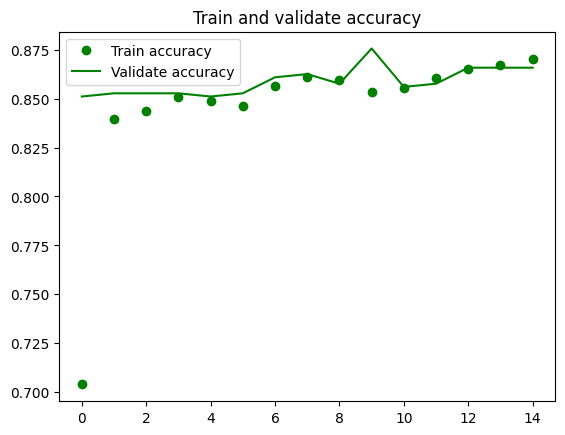

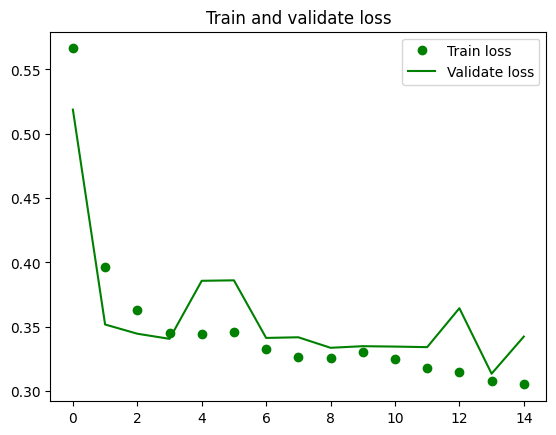

In [ ]:
import matplotlib.pyplot as plt

acc = history_w.history['acc']                          #we can normalize input data in improve the model
val_acc = history_w.history['val_acc']
loss = history_w.history['loss']
val_loss = history_w.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            #pop up the list for train and validate acc box

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()                                             #show the graph

### 2-layer LSTM

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, PReLU, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

epochs = 15
emb_dim = 32
batch_size = 200
model_y = Sequential()
model_y.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=30, weights=[embedding_matrix], trainable=False))
model_y.add(LSTM(50, dropout=0.3, recurrent_dropout=0.5, return_sequences=True))
model_y.add(LSTM(200, dropout=0.2, recurrent_dropout =0.5))
model_y.add(Dense(2, activation='softmax'))
model_y.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_y.summary())                                                                           #categorical_crossentropy
history_y = model_y.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 100)           1789100   
                                                                 
 lstm_5 (LSTM)               (None, 30, 50)            30200     
                                                                 
 lstm_6 (LSTM)               (None, 200)               200800    
                                                                 
 dense_5 (Dense)             (None, 2)                 402       
                                                                 
Total params: 2020502 (7.71 MB)
Trainable params: 231402 (903.91 KB)
Non-trainable params: 1789100 (6.82 MB)
_________________________________________________________________
None
Epoch 1/15
25/25 [==============================] - 12s 191ms/step - loss: 0.4492 - acc: 0.7952 - val_loss: 0.3526 - val_acc: 0.8584
Epoch

In [ ]:
loss, accuracy = model_y.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

95/95 [==============================] - 2s 23ms/step - loss: 0.2377 - acc: 0.9013
Test Accuracy: 90.13%


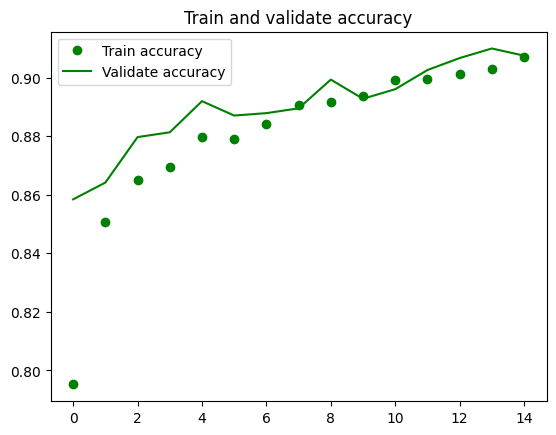

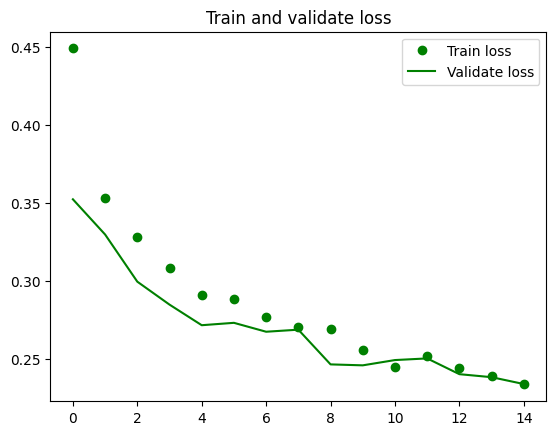

In [ ]:
acc = history_y.history['acc']                          #we can normalize input data in improve the model
val_acc = history_y.history['val_acc']
loss = history_y.history['loss']
val_loss = history_y.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            #pop up the list for train and validate acc box

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()                                             #show the graph

### CNN + LSTM

In [ ]:
from keras.layers import Conv1D ,MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

epochs = 15
emb_dim = 15
batch_size = 200
model_Z = Sequential()
model_Z.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=30, weights=[embedding_matrix], trainable=False))
model_Z.add(Conv1D(300, 6, padding='same'))
model_Z.add(Activation('relu'))
model_Z.add(MaxPooling1D(pool_size=2))
model_Z.add(Dropout(0.6))
model_Z.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model_Z.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model_Z.add(Dense(2, activation='softmax'))
model_Z.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_Z.summary())                                                                           #categorical_crossentropy
historyZ = model_Z.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 100)           1789100   
                                                                 
 conv1d (Conv1D)             (None, 30, 300)           180300    
                                                                 
 activation (Activation)     (None, 30, 300)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 300)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                                 
 lstm_7 (LSTM)               (None, 15, 100)           160400    
                                                      

In [ ]:
loss, accuracy = model_Z.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

95/95 [==============================] - 2s 16ms/step - loss: 0.2905 - acc: 0.9063
Test Accuracy: 90.63%


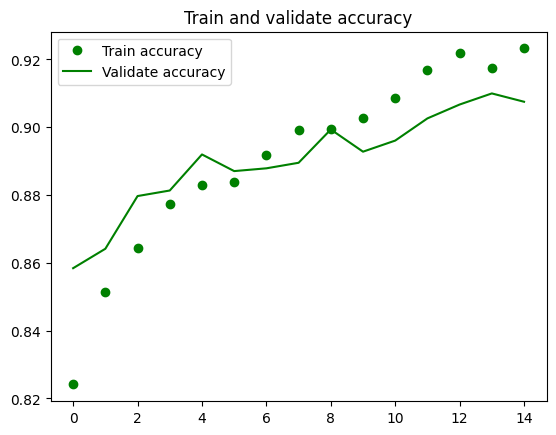

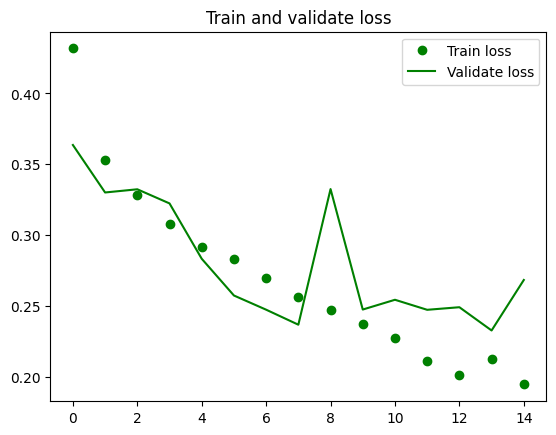

In [ ]:
acc = historyZ.history['acc']                          #plot the graph that contains accuracy, loss and val_loss
loss = historyZ.history['loss']
val_loss = historyZ.history['val_loss']


plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            #pop up the list for train and validate acc box

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()                                             #show the graph